In [1]:
%matplotlib inline

# Compute a Galactic orbit for a star using Gaia data

In this tutorial, we will retrieve the sky coordinates, astrometry, and radial velocity for a star — [Kepler-444](https://en.wikipedia.org/wiki/Kepler-444) — and compute its orbit in the default Milky Way mass model implemented in Gala. We will compare the orbit of Kepler-444 to the orbit of the Sun.

### Notebook Setup and Package Imports

In [2]:
import astropy.coordinates as coord
import astropy.units as u
import matplotlib.pyplot as plt
from pyia import GaiaData
import numpy as np

# Gala
import gala.dynamics as gd
import gala.potential as gp

from simulate_helpers import *
from tqdm import tqdm

/Users/chrislam/Desktop/mastrangelo/src/mastrangelo/simulate_helpers.py:32: SyntaxWarning: invalid escape sequence '\s'
  """
/Users/chrislam/Desktop/mastrangelo/src/mastrangelo/simulate_helpers.py:204: SyntaxWarning: invalid escape sequence '\s'
  limbach = pd.read_csv(path+'limbach_cdfs.txt', engine='python', header=0, sep='\s{2,20}') # space-agnostic separator
/Users/chrislam/Desktop/mastrangelo/src/mastrangelo/simulate_helpers.py:907: SyntaxWarning: invalid escape sequence '\o'
  """


In [4]:
from astropy.table import Table, join
path = '/Users/chrislam/Desktop/mastrangelo/'
berger = Table.read(path+'data/berger_kepler_stellar_fgk.csv')
#path = '/home/c.lam/blue/sculpting2/'
#berger = Table.read(path+'berger_kepler_stellar_fgk.csv')


In [5]:
megan = Table.read(path+'data/kepler_dr3_good.fits')

In [6]:
merged = join(berger, megan, keys='kepid')
merged.rename_column('parallax_2', 'parallax')

In [7]:
merged.to_pandas()

,kepid,tm_designation_1,teff_1,teff_err1_1,teff_err2_1,logg_1,logg_err1_1,logg_err2_1,feh_x,feh_err1_1,...,mass_err2_2,prov_sec_2,nconfp_2,nkoi_2,ntce_2,jmag_2,hmag_2,kmag,planet?,kepler_gaia_mag_diff
0,757280,2MASS J19242289+3633538,6543,162.0,-194.0,4.082,0.258,-0.172,-0.24,0.25,...,-0.157,b'DSEP',0,0,0,10.852,10.662,10.627,b'none',-0.131530
1,892195,2MASS J19240520+3638374,5522,194.0,-155.0,3.984,0.510,-0.170,-0.06,0.30,...,-0.120,b'DSEP',0,0,0,12.316,11.949,11.814,b'none',-0.094934
2,892667,2MASS J19243045+3637186,6609,159.0,-227.0,4.105,0.246,-0.164,-0.26,0.25,...,-0.236,b'DSEP',0,0,1,12.088,11.856,11.818,b'none',-0.115383
3,892678,2MASS J19243108+3638316,6137,167.0,-186.0,3.936,0.428,-0.143,-0.26,0.30,...,-0.204,b'DSEP',0,0,0,10.946,10.646,10.580,b'none',-0.117199
4,892713,2MASS J19243353+3637220,6106,186.0,-186.0,3.854,0.496,-0.124,-0.24,0.30,...,-0.270,b'DSEP',0,0,0,10.853,10.588,10.508,b'none',-0.104743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69194,12935035,2MASS J19204068+5218589,6071,192.0,-234.0,3.992,0.382,-0.127,-0.06,0.25,...,-0.198,b'DSEP',0,0,0,10.406,10.136,10.089,b'none',-0.027611
69195,12983952,2MASS J19194126+5224230,5365,175.0,-191.0,4.571,0.032,-0.136,0.12,0.25,...,-0.099,b'DSEP',0,0,0,13.837,13.467,13.333,b'none',-0.007741
69196,12984000,2MASS J19194837+5225067,5835,174.0,-192.0,4.464,0.084,-0.196,-0.26,0.30,...,-0.088,b'DSEP',0,0,0,13.650,13.329,13.194,b'none',-0.012257
69197,12984200,2MASS J19201625+5224552,5862,161.0,-161.0,4.459,0.084,-0.182,-0.28,0.30,...,-0.089,b'DSEP',0,0,0,13.506,13.069,13.046,b'none',-0.028408


## Define a Galactocentric Coordinate Frame

We will start by defining a Galactocentric coordinate system using `astropy.coordinates` by adopting the latest parameter set for the Solar position and velocity with respect to the Galactic Center implemented in Astropy.

In [8]:
with coord.galactocentric_frame_defaults.set("v4.0"):
    galcen_frame = coord.Galactocentric()
galcen_frame

<Galactocentric Frame (galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=20.8 pc, roll=0.0 deg)>

## Define the Solar Position and Velocity

In this coordinate system, the sun is along the $x$-axis (at a negative $x$ value), and the Galactic rotation at this position is in the $+y$ direction. In this coordinate system, the 3D position of the sun is therefore given by:

In [9]:
sun_xyz = u.Quantity(
    [-galcen_frame.galcen_distance, 0 * u.kpc, galcen_frame.z_sun]  # x  # y  # z
)

We can combine this with the solar velocity vector (set on the `astropy.coordinates.Galactocentric` frame) to define the sun's phase-space position, which we will use as initial conditions shortly to compute the orbit of the Sun:

In [10]:
sun_w0 = gd.PhaseSpacePosition(pos=sun_xyz, vel=galcen_frame.galcen_v_sun)

To compute the sun's orbit, we need to specify a mass model for the Galaxy. Here, we will use the same default, four-component Milky Way mass model introduced in [Defining a Milky Way model](define-milky-way-model.html):

In [11]:
mw_potential = gp.MilkyWayPotential()

We can now compute the Sun's orbit using the default integrator (Leapfrog integration): We will compute the orbit for 4 Gyr, which is about 16 orbital periods:

In [12]:
sun_orbit = mw_potential.integrate_orbit(sun_w0, dt=0.5 * u.Myr, t1=0, t2=16 * u.Gyr)

In [13]:
# # maybe you dont need this
import astropy.units as u
# star_sky_c = coord.SkyCoord(ra=merged['ra'], dec=merged['dec'], unit=u.degree)
# star_sky_c

We happen to know a priori that Kepler-444 has a large proper motion, so the sky position reported by Simbad (unknown epoch) could be off from the Gaia sky position (epoch=2016) by many arcseconds. To run and retrieve the Gaia data, we will use the [pyia](http://pyia.readthedocs.io/) package: We can pass in an ADQL query, which `pyia` uses to query the Gaia science archive using `astroquery`, and returns the data as a `pyia` object that understands how to convert the Gaia data columns into a `astropy.coordinates.SkyCoord` object. To run the query, we will do a large sky position cross-match (with a radius of 15 arcseconds), and take the brightest cross-matched source within this region:

In [14]:
star_gaia = GaiaData(merged)

We will assume (and hope!) that this source is Kepler-444, but we know that it is fairly bright compared to a typical Gaia source, so we should be safe.

We can now use the returned `pyia.GaiaData` object to convert the Gaia astrometric and radial velocity measurements into an Astropy `SkyCoord` object (with all position and velocity data):

In [15]:
star_gaia_c = star_gaia.get_skycoord()

To compute this star's Galactic orbit, we need to convert its observed, Heliocentric (actually solar system barycentric) data into the Galactocentric coordinate frame we defined above. To do this, we will use the `astropy.coordinates` transformation framework:

In [16]:
star_galcen = star_gaia_c.transform_to(galcen_frame)
star_galcen

<SkyCoord (Galactocentric: galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=20.8 pc, roll=0.0 deg): (x, y, z) in pc
    [(-7809.53180464,  820.33773985, 170.7221152 ),
     (-7961.50957819,  422.29028598,  98.67032167),
     (-7706.92196028, 1093.36446921, 220.60036776), ...,
     (-7902.36614697, 1956.19870782, 626.46406831),
     (-7949.44356043, 1543.02874181, 496.54140753),
     (-8062.94084951,  533.95437875, 185.31835985)]
 (v_x, v_y, v_z) in km / s
    [( 17.65215344, 224.84388962,   1.52409743),
     ( 24.63565621, 229.22636899,  -1.23425939),
     ( 65.60029784, 238.43625266,  16.33568858), ...,
     (         nan,          nan,          nan),
     ( 76.14554242, 198.46087019, -46.37845744),
     (-73.60929913, 199.48350711, -41.27816092)]>

Now with Galactocentric position and velocity components for Kepler-444, we can create Gala initial conditions and compute its orbit on the time grid used to compute the Sun's orbit above:

In [17]:
star_w0 = gd.PhaseSpacePosition(star_galcen.data)

In [20]:
star_orbit = mw_potential.integrate_orbit(star_w0[:10], t=sun_orbit.t)

In [21]:
zmaxes2 = star_orbit.zmax()

In [22]:
print(star_gaia[0:10])

        ra                dec         ...        pmdec        radial_velocity
       deg                deg         ...  0.001 arcsec / yr       km / s    
------------------ ------------------ ... ------------------- ---------------
 291.0953727428411  36.56490237614381 ... -2.8412896292792116      -18.505922
291.02166295755393 36.643646983846004 ...   -8.34607796361622     -12.5067005
 291.1268788916715  36.62178185002908 ... -7.7082643405854245       13.275185
 291.1294950551968   36.6420709497822 ...  -5.056522969836806      -31.519499
 291.1397018204042 36.622707397577585 ...  -9.917033847440297      -5.0609126
291.16268754960134  36.62124424156081 ...  1.7057010713386025      -7.6975026
291.17969357169954  36.67056963522391 ...  1.4918959019173066              --
 291.1876128968787  36.67247075862457 ... -3.5442529243124063              --
 291.1950286195971 36.672420461318566 ...   3.732966757946107       -54.55454
 291.1963963179211  36.66834033001497 ...  -2.809588952410715   

Ma+ 2017 scale heights, for comparison

In [23]:
import simulate_helpers
import pandas as pd

berger_kepler = pd.read_csv(path+'data/berger_kepler_stellar_fgk.csv') # crossmatched with Gaia via Bedell

berger_kepler_temp = simulate_helpers.draw_asymmetrically(berger_kepler, 'iso_rad', 'iso_rad_err1', 'iso_rad_err2', 'stellar_radius')
berger_kepler_temp = simulate_helpers.draw_asymmetrically(berger_kepler_temp, 'iso_age', 'iso_age_err1', 'iso_age_err2', 'age')
berger_kepler_temp = simulate_helpers.draw_asymmetrically(berger_kepler_temp, 'iso_mass', 'iso_mass_err1', 'iso_mass_err2', 'stellar_mass')
berger_kepler_temp = simulate_helpers.draw_galactic_heights(berger_kepler_temp)


/var/folders/tt/rlpbr2fs7lx14h3f5_21mr240000gn/T/ipykernel_45410/228351311.py:4: DtypeWarning: Columns (138) have mixed types. Specify dtype option on import or set low_memory=False.
  berger_kepler = pd.read_csv(path+'data/berger_kepler_stellar_fgk.csv') # crossmatched with Gaia via Bedell
/Users/chrislam/Desktop/mastrangelo/src/mastrangelo/simulate_helpers.py:562: RuntimeWarning: invalid value encountered in log
  factor2_arg_a = np.log(1+gamma*(x - mode))
/Users/chrislam/Desktop/mastrangelo/src/mastrangelo/simulate_helpers.py:641: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[drawn] = df[drawn].fillna(method='ffill')
/Users/chrislam/Desktop/mastrangelo/src/mastrangelo/simulate_helpers.py:562: RuntimeWarning: invalid value encountered in log
  factor2_arg_a = np.log(1+gamma*(x - mode))
/Users/chrislam/Desktop/mastrangelo/src/mastrangelo/simulate_helpers.py:641: FutureWarning: Series.fillna wit

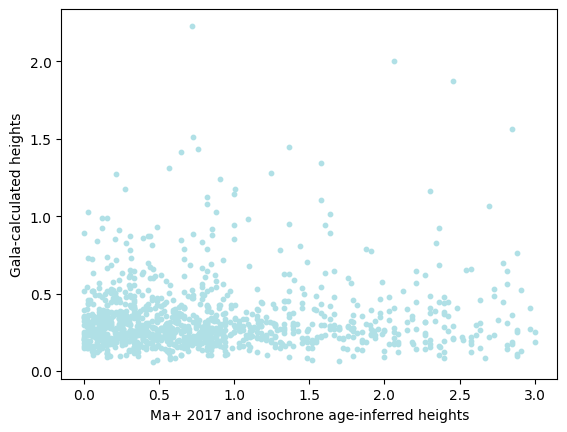

In [30]:
plt.scatter(berger_kepler_temp['height'][:1000]/1000, zmaxes, s=10, color='powderblue')
plt.scatter(berger_kepler_temp['height'][1000:2000]/1000, zmaxes2, s=10, color='powderblue')

plt.xlabel('Ma+ 2017 and isochrone age-inferred heights')
plt.ylabel('Gala-calculated heights')
plt.show()

In [24]:
len(star_gaia)

69199

There's like no relation between the two lol. 

Now, how about we try to plot z vs v_z vs v_r, like in Antojas+ 2018

In [25]:
star_orbit.vel[-1][0].d_z # kpc/Myr

<Quantity 0.00971457 kpc / Myr>

In [26]:
star_orbit.pos[-1][0].z # kpc

<Quantity -0.11385364 kpc>

In [27]:
cstar_orbit = star_orbit.cylindrical
cstar_orbit[0].vel[0] 

<CylindricalDifferential (d_rho, d_phi, d_z) in (kpc / Myr, rad / Myr, kpc / Myr)
    (0.00606827, -0.02936369, 0.00155871)>

In [28]:
dist = star_orbit.spherical.distance

In [29]:
dist[-1]

<Distance [7.38312894, 8.01023026, 8.30821138, 6.64466264, 7.49491905,
           7.74240197,        nan,        nan, 8.35454932,        nan] kpc>

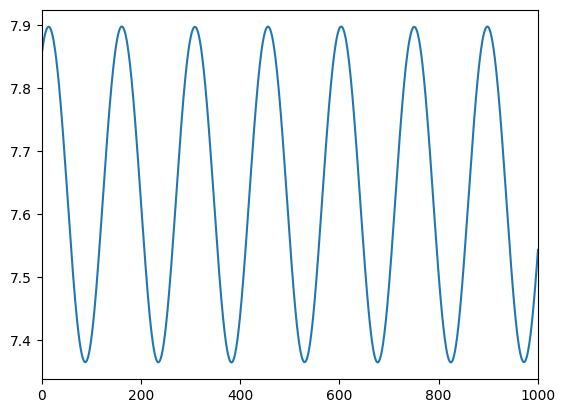

In [30]:
orbit = mw_potential.integrate_orbit(star_w0[0], t=sun_orbit.t)

plt.plot(orbit.t, orbit.spherical.distance, marker="None")
plt.xlim([0, 1000])
plt.show()

In [31]:
np.nanmean(orbit.spherical.distance.value)

7.635849094397982

In [32]:
zmaxes = pd.read_csv(path+'data/zmaxes.csv')
len(zmaxes)

69199

In [33]:
ages = merged['iso_age']

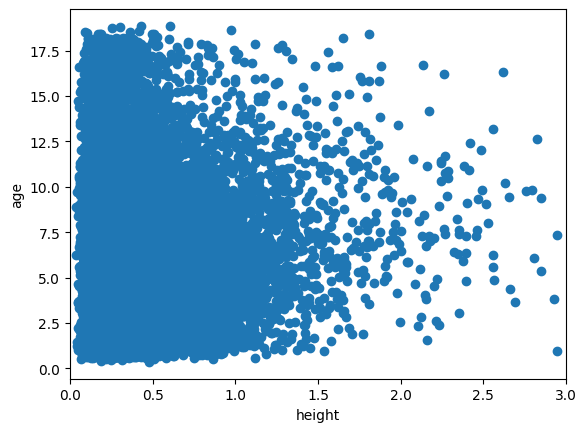

In [34]:
plt.scatter(zmaxes, ages)
plt.ylabel('age')
plt.xlabel('height')
plt.xlim([0, 3])
plt.show()

- gala heights don't seem to covary with Berger isochrone ages
- Kepler is a highly biased sample, which is informed by the cone shape, with heavy preference for bright G dwarfs in the thin disk
- Sarah wants: for a given Teff slice, eg. only 5000-5500 K, see four bins [0-500 pc age distribution; 500-1000 pc age distribution; etc]
- There will be some scatter, but she expects some relationship 
- Luke Bouma recent arXiv paper used rotation period and Li abundances to get ages for 23K stars 

In [35]:
merged_df = merged.to_pandas()
merged_df['height'] = zmaxes*1000
merged_df = merged_df.dropna(subset=['height'])
merged_sub = merged_df.loc[(merged_df['iso_teff'] >= 5000) & (merged_df['iso_teff'] < 5500)]


/Users/chrislam/Desktop/mastrangelo/src/mastrangelo/simulate_helpers.py:562: RuntimeWarning: invalid value encountered in log
  factor2_arg_a = np.log(1+gamma*(x - mode))
/Users/chrislam/Desktop/mastrangelo/src/mastrangelo/simulate_helpers.py:681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age'] = ages
/Users/chrislam/Desktop/mastrangelo/src/mastrangelo/simulate_helpers.py:685: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['age'] = df.age.fillna(method='ffill')
/Users/chrislam/Desktop/mastrangelo/src/mastrangelo/simulate_helpers.py:562: RuntimeWarning: invalid value encountered in log
  factor2_arg_a = np.log(1+gamma*(x - mode))
/Users/chrislam/Desk

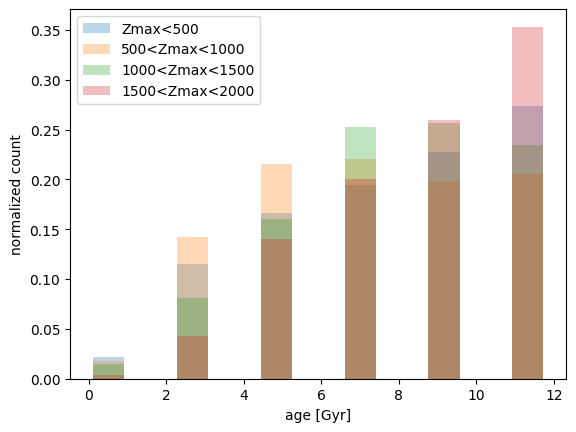

In [37]:
### with such large age uncertainty, we should bootstrap and marginalize by adding the age histograms for different slice regimes

sub1 = []
sub2 = []
sub3 = []
sub4 = []
x = np.linspace(0.5, 13.5, 7)

for i in range(10):
    # draw stellar ages
    merged_sub_age = simulate_helpers.draw_star_ages(merged_sub) # merged_df, merged_sub

    # split into gala-calculated scale heights
    merged_sub1 = merged_sub_age.loc[merged_sub_age['height'] < 500]
    merged_sub2 = merged_sub_age.loc[(merged_sub_age['height'] >= 500) & (merged_sub_age['height'] < 1000)]
    merged_sub3 = merged_sub_age.loc[(merged_sub_age['height'] >= 1000) & (merged_sub_age['height'] < 1500)]
    merged_sub4 = merged_sub_age.loc[(merged_sub_age['height'] >= 1500) & (merged_sub_age['height'] < 2000)]

    sub1.append(np.histogram(merged_sub1['age'], bins=x)[0])
    sub2.append(np.histogram(merged_sub2['age'], bins=x)[0])
    sub3.append(np.histogram(merged_sub3['age'], bins=x)[0])
    sub4.append(np.histogram(merged_sub4['age'], bins=x)[0])

sub1_total = np.sum(sub1, axis=0)
sub2_total = np.sum(sub2, axis=0)
sub3_total = np.sum(sub3, axis=0)
sub4_total = np.sum(sub4, axis=0)

sub1_norm = sub1_total/np.sum(sub1_total)
sub2_norm = sub2_total/np.sum(sub2_total)
sub3_norm = sub3_total/np.sum(sub3_total)
sub4_norm = sub4_total/np.sum(sub4_total)

plt.bar(x[:-1], sub1_norm, alpha=0.3, label='Zmax<500')
plt.bar(x[:-1], sub2_norm, alpha=0.3, label='500<Zmax<1000')
plt.bar(x[:-1], sub3_norm, alpha=0.3, label='1000<Zmax<1500')
plt.bar(x[:-1], sub4_norm, alpha=0.3, label='1500<Zmax<2000')

plt.xlabel('age [Gyr]')
plt.ylabel('normalized count')
plt.legend()
plt.show()


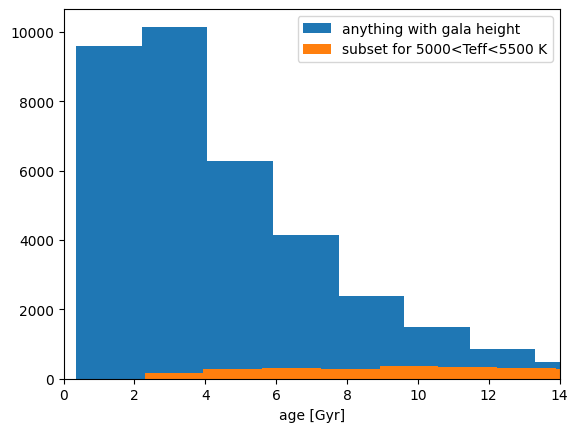

In [156]:
plt.hist(merged_df['iso_age'], label='anything with gala height')
plt.hist(merged_sub['iso_age'], label='subset for 5000<Teff<5500 K')
plt.xlabel('age [Gyr]')
plt.xlim([0, 14])
plt.legend()
plt.show()

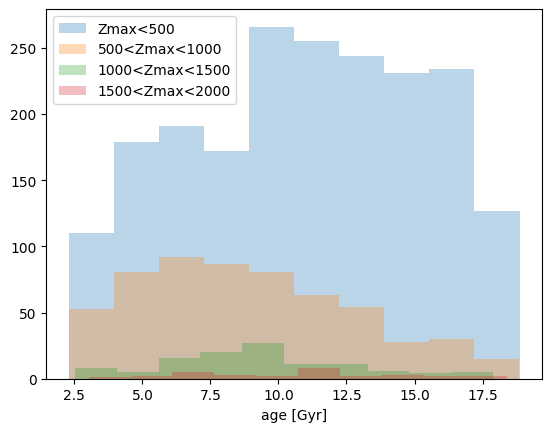

In [108]:
plt.hist(merged_sub1['iso_age'], alpha=0.3, label='Zmax<500')
plt.hist(merged_sub2['iso_age'], alpha=0.3, label='500<Zmax<1000')
plt.hist(merged_sub3['iso_age'], alpha=0.3, label='1000<Zmax<1500')
plt.hist(merged_sub4['iso_age'], alpha=0.3, label='1500<Zmax<2000')
plt.xlabel('age [Gyr]')
plt.legend()
plt.show()